# Binary classification with Scikit-Learn

In [1]:
import sklearn

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

## Our task

UCI ML Breast Cancer Wisconsin (Diagnostic) dataset, which contains 569 biopsies of a suspect breast cancer that can be either *malignat* or *benign*.
Sample features are descriptors of the cell nuclei present in the image of each biopsy.

Details here https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset

In [4]:
from sklearn.datasets import load_breast_cancer

In [5]:
X, y = load_breast_cancer(return_X_y=True)

In [6]:
X.shape, y.shape

((569, 30), (569,))

In [7]:
y_classes, y_counts = np.unique(y, return_counts=True)

<BarContainer object of 2 artists>

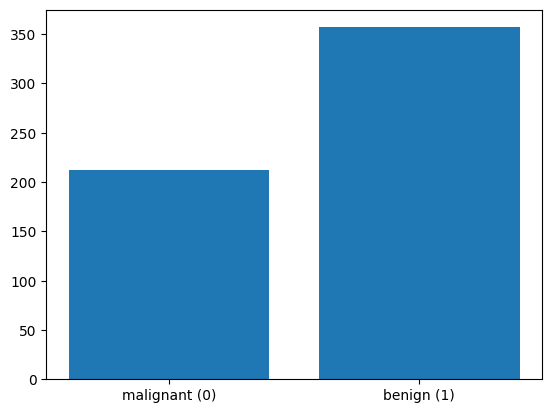

In [8]:
plt.bar(["malignant (0)", "benign (1)"], y_counts)

### Construct selection and test sets

Now we create an arbitrarily split in order to have a selection set and a test set for the next experiments. Usually those splits are given by the task, e.g. ML Cup dataset for students and blind test set for the teacher.

In [9]:
from sklearn.datasets import load_breast_cancer

In [10]:
X, y = load_breast_cancer(return_X_y=True)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=100, stratify=y, shuffle=True, random_state=42
)

In [13]:
X_dev.shape, X_test.shape

((469, 30), (100, 30))

## Evaluation metrics

We'll now see some evaluation metrics for a (binary) classifier, using a dummy baseline as an example

### A baseline classifier

An extremely naive baseline classifier returns always the *most frequent class* as prediction:

In [14]:
np.unique(y_dev, return_counts=True)

(array([0, 1]), array([175, 294]))

In [15]:
y_pred = np.ones_like(y_dev)

In [16]:
y_test_pred = np.ones_like(y_test)

### Evaluating the baseline

In [17]:
from sklearn.metrics import *

Accuracy: ratio of correct predictions

In [18]:
accuracy_score(y_test, y_test_pred)

0.63

Balanced accuracy: ratio of correct predictions in each class weighted by class frequency

In [19]:
balanced_accuracy_score(y_test, y_test_pred)

0.5

The confusion matrix lets us see how the classifier is behaving on the different classes

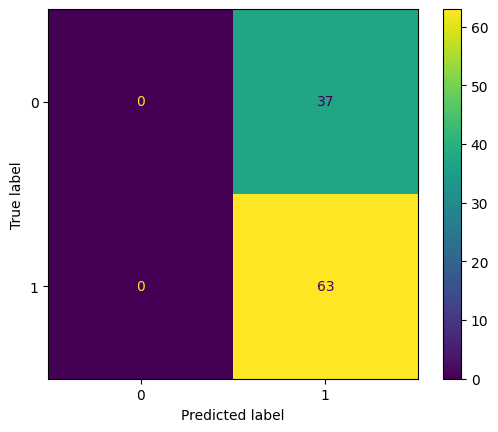

In [20]:
cm = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(cm).plot()

Let's try with a *random guess* classifier instead:

In [21]:
y_test_pred = np.random.randint(2, size=y_test.shape)

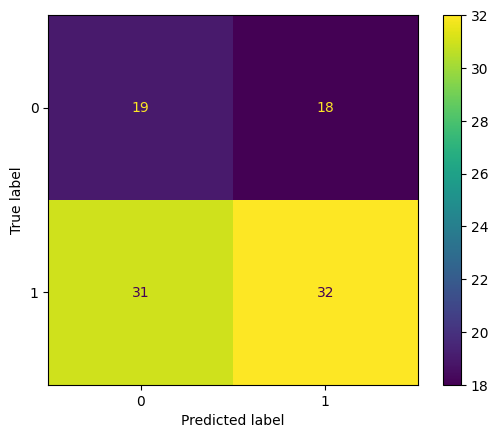

In [22]:
cm = confusion_matrix(y_test, y_test_pred)

ConfusionMatrixDisplay(cm).plot()

For unbalanced classes where one class is of particular interest, such as malignant cancer in our case, other metrics can be useful that consider *precision* and *recall* of the classifier:

![image.svg](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [23]:
(
    precision_score(y_test, y_test_pred, pos_label=0),
    recall_score(y_test, y_test_pred, pos_label=0),
)

(0.38, 0.5135135135135135)

In [24]:
(
    precision_score(y_test, y_test_pred, pos_label=1),
    recall_score(y_test, y_test_pred, pos_label=1),
)

(0.64, 0.5079365079365079)

F1 is the harmonic mean of precision and recall

In [25]:
f1_score(y_test, y_test_pred, pos_label=0), f1_score(y_test, y_test_pred, pos_label=1)

(0.4367816091954023, 0.5663716814159292)

In the medical field, the receiver operating characteristic (ROC) curve is used to display the trade-off between false positive rate ("false alarms") and true positive rate

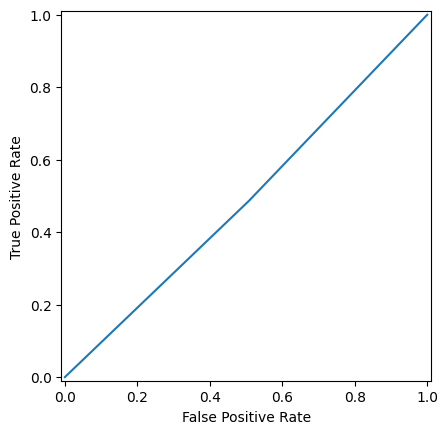

In [26]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred, pos_label=0)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [27]:
roc_auc_score(y_test, y_test_pred)

0.5107250107250108

## Data transformations

Models can benefit from a normalization of feature values, e.g. in k-NN when computing distances between sample vectors $\mathbf{x} = [x_1, x_2]$, so distances in one feature with values in a smaller scale (e.g. $x_1 \in [0,1]$) will not be trumped by distances in another feature with larger scale (e.g. $x_2 \in [0, 1000]$).

In [28]:
from sklearn.preprocessing import *

[]

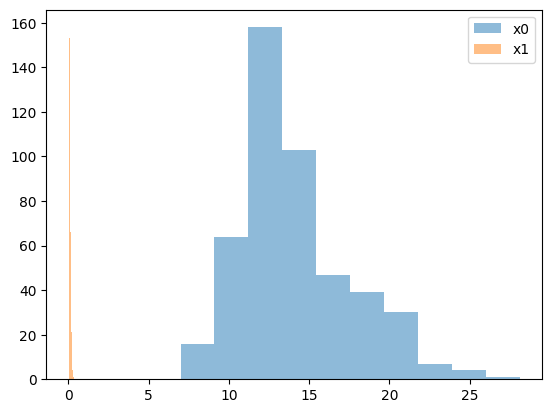

In [29]:
plt.hist(X_dev[:, 0], alpha=0.5, label="x0")
plt.hist(X_dev[:, 5], alpha=0.5, label="x1")
plt.legend(loc="upper right")
plt.plot()

- Rescale values between minimimum and maximum:

In [30]:
scaler = MinMaxScaler()

In [31]:
scaler.fit(X_dev)

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [32]:
X_dev_scaled = scaler.transform(X_dev)

[]

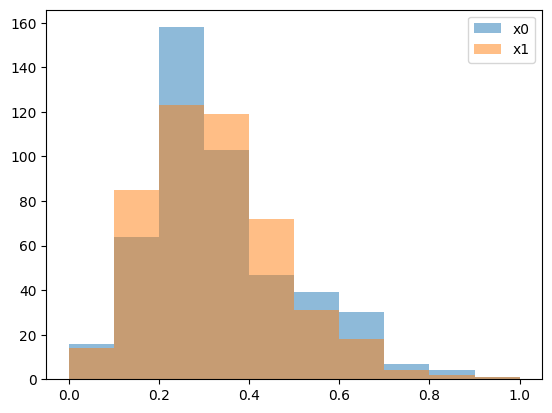

In [33]:
plt.hist(X_dev_scaled[:, 0], alpha=0.5, label="x0")
plt.hist(X_dev_scaled[:, 1], alpha=0.5, label="x1")
plt.legend(loc="upper right")
plt.plot()

- Normalize values with mean and standard deviation:

In [34]:
scaler = StandardScaler()

In [35]:
scaler.fit(X_dev)

,copy,True
,with_mean,True
,with_std,True


In [36]:
X_dev_scaled = scaler.transform(X_dev)

[]

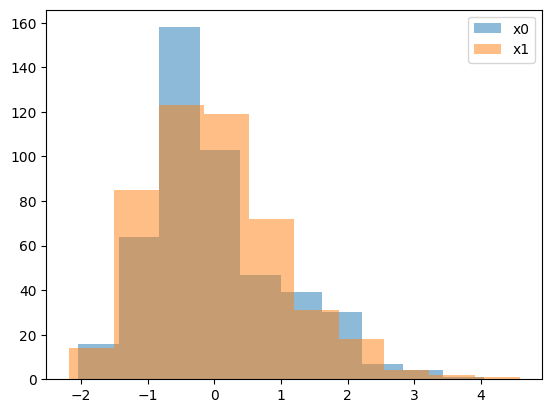

In [37]:
plt.hist(X_dev_scaled[:, 0], alpha=0.5, label="x0")
plt.hist(X_dev_scaled[:, 1], alpha=0.5, label="x1")
plt.legend(loc="upper right")
plt.plot()

## Nearest neighbour

k-NN returns the majority class of the $k$ samples that are closest to $\mathbf{x}$.

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
model = KNeighborsClassifier(
    n_neighbors=3,  # number of neighbours
    weights="uniform",  # or weight proportional to the inverse of the distance
    metric="minkowski",  # or other user-defined distances
    p=2,
)  # p-norm for 'minkowski' metric

By "Minkowski" distance here it is denoted the $p$-norm of a vector $\mathbf{x} - \mathbf{y}$, defined as $\lVert\mathbf{x} - \mathbf{y}\rVert_p = \sqrt[p]{\sum_k (x_k - y_k)^p}$

In [40]:
model.fit(X_dev, y_dev)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [41]:
accuracy_score(y_test, model.predict(X_test))

0.93

You can also combine a feature scaler with a classifier model in a single pipeline:

In [42]:
from sklearn.pipeline import make_pipeline

In [43]:
model = make_pipeline(MinMaxScaler(), KNeighborsClassifier())

In [44]:
model.fit(X_dev, y_dev)

,steps,"[('minmaxscaler', ...), ('kneighborsclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,feature_range,"(0, ...)"
,copy,True
,clip,False
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30


In [45]:
accuracy_score(y_test, model.predict(X_test))

0.97

Parameters can be accessed as `<step>.<parameter>` (useful for model selection, as we're about to see)

In [46]:
model.named_steps

{'minmaxscaler': MinMaxScaler(),
 'kneighborsclassifier': KNeighborsClassifier()}

In [47]:
model.named_steps["kneighborsclassifier"].n_neighbors

5

## Model selection

Scikit-learns offers helper classes to automaticall split a dataset in k-folds and to perform model parameter selection

### K-Fold cross-validation

In [48]:
from sklearn.model_selection import KFold, StratifiedKFold

In [49]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [50]:
kfold.split(X_dev, y_dev)

<generator object _BaseKFold.split at 0x7fbfc89ca020>

A generator which returns pairs of `(train_fold_indices, validation_fold_indices)`:

In [51]:
list(kfold.split(X_dev, y_dev))

[(array([  1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  13,  14,  16,
          17,  20,  21,  22,  23,  24,  26,  27,  28,  29,  31,  32,  34,
          35,  36,  37,  38,  40,  41,  43,  44,  45,  46,  47,  48,  49,
          50,  51,  52,  53,  54,  57,  58,  59,  60,  61,  62,  64,  65,
          66,  67,  68,  69,  71,  74,  80,  81,  83,  84,  85,  86,  87,
          88,  89,  91,  92,  94,  95,  96,  97,  98,  99, 100, 102, 103,
         104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 118,
         119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 133, 134,
         135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 150,
         151, 152, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 174, 176, 177, 178, 179, 181, 182, 183,
         184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197,
         198, 199, 200, 201, 202, 204, 205, 206, 207, 209, 211, 212, 213,
         214, 215, 216, 217, 219, 221,

In case of classification, it could be useful to use `StratifiedKFold` in order to keep the same class ratio in all splits

In [52]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

For a double cross-validation, just nest a two k-fold splits in a loop:

In [53]:
outer_kfold = KFold(n_splits=10)
inner_kfold = KFold(n_splits=5)

for selection_indices, test_indices in outer_kfold.split(X, y):
    for train_indices, validation_indices in inner_kfold.split(
        X[selection_indices], y[selection_indices]
    ):
        ...

### Validation curve

We can now analyze the impact of the parameter $k$ in a k-NN classifier on validation accuracy:

In [54]:
from sklearn.model_selection import validation_curve

In [55]:
k = np.arange(1, 10)

In [56]:
train_scores, validation_scores = validation_curve(
    KNeighborsClassifier(),
    X_dev,
    y_dev,
    param_name="n_neighbors",
    param_range=k,
    scoring="balanced_accuracy",
    cv=kfold,
)

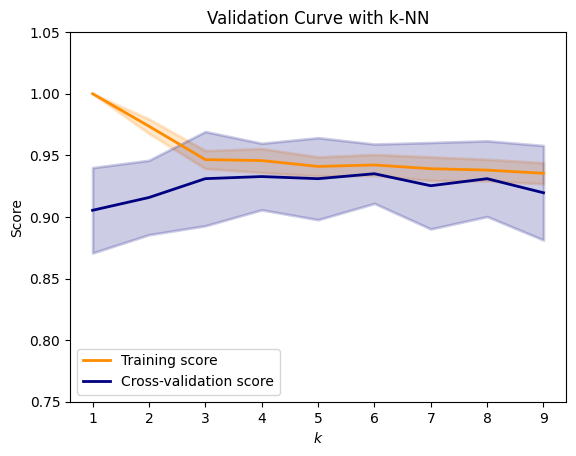

In [57]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(validation_scores, axis=1)
valid_scores_std = np.std(validation_scores, axis=1)

plt.title("Validation Curve with k-NN")
plt.xlabel(r"$k$")
plt.ylabel("Score")
plt.ylim(0.75, 1.05)
lw = 2
plt.plot(k, train_scores_mean, label="Training score", color="darkorange", lw=lw)
plt.fill_between(
    k,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(k, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
plt.fill_between(
    k,
    valid_scores_mean - valid_scores_std,
    valid_scores_mean + valid_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="lower left")
plt.show()

### Hyper-parameter search

Instead of manually searching the combination of parameters, Scikit-learns offers classes that automate hyper-parameter selection

- Generation of all parameter combinations

In [58]:
from sklearn.model_selection import ParameterGrid

In [59]:
param_values = {"n_neighbors": [1, 2, 3, 4, 5], "p": [1, 2]}

In [60]:
list(ParameterGrid(param_values))

[{'n_neighbors': 1, 'p': 1},
 {'n_neighbors': 1, 'p': 2},
 {'n_neighbors': 2, 'p': 1},
 {'n_neighbors': 2, 'p': 2},
 {'n_neighbors': 3, 'p': 1},
 {'n_neighbors': 3, 'p': 2},
 {'n_neighbors': 4, 'p': 1},
 {'n_neighbors': 4, 'p': 2},
 {'n_neighbors': 5, 'p': 1},
 {'n_neighbors': 5, 'p': 2}]

- Grid search

`GridSearchCV` performs an exhaustive search of model hyper-parameters that maximize the average score on a cross-validation split

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
hp_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_values,
    scoring="balanced_accuracy",
    refit=True,
    cv=kfold,
)

In [63]:
hp_search.fit(X_dev, y_dev)

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [1, 2, ...], 'p': [1, 2]}"
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,5


In the grid search object you can access different statistics of the model selection such as paramters and scores, best estimator, training times, etc

In [64]:
hp_search.cv_results_

{'mean_fit_time': array([0.00090885, 0.00082707, 0.00130744, 0.00065956, 0.00089436,
        0.00115047, 0.00147734, 0.00114551, 0.0006567 , 0.00141053]),
 'std_fit_time': array([2.57217915e-04, 3.20855323e-04, 7.56248135e-04, 1.72517654e-04,
        4.62923680e-04, 4.26457910e-04, 1.67358780e-03, 6.58374550e-04,
        9.44458541e-05, 9.36663859e-04]),
 'mean_score_time': array([0.00401239, 0.07534194, 0.0036027 , 0.0282805 , 0.00306263,
        0.03456135, 0.00278621, 0.0566236 , 0.0040699 , 0.04520988]),
 'std_score_time': array([0.00071414, 0.09340484, 0.00047486, 0.00980023, 0.00050828,
        0.00519539, 0.00054026, 0.0397979 , 0.00146103, 0.03080531]),
 'param_n_neighbors': masked_array(data=[1, 1, 2, 2, 3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value=999999),
 'param_p': masked_array(data=[1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
              mask=[False, False, False, False, False, Fa

In [65]:
hp_search.best_estimator_

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,1
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [66]:
hp_search.best_score_

np.float64(0.9412974868497954)

In [67]:
hp_search.best_params_

{'n_neighbors': 5, 'p': 1}

We can now evaluate the best model on the test set:

In [68]:
hp_search.score(X_test, y_test)

0.9141999141999142

- Random search

Since the hyper-parameter space grows exponentially with the number of parameters, another strategy is to sample uniformly this space as a trade-off between computation time and hyper-parameter exploration

In [69]:
from sklearn.model_selection import RandomizedSearchCV

You can also choose the distribution of parameter, instead of just enumerating them, e.g. for continously valued params

In [70]:
from scipy.stats import uniform

In [71]:
hp_rsearch = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_distributions={"n_neighbors": [1, 2, 3, 4, 5], "p": uniform(loc=1, scale=2)},
    n_iter=5,  # how many hyper-parameter combinations to sample
    scoring="balanced_accuracy",
    refit=True,
    cv=kfold,
)

In [72]:
hp_rsearch.fit(X_dev, y_dev)

,estimator,KNeighborsClassifier()
,param_distributions,"{'n_neighbors': [1, 2, ...], 'p': <scipy.stats....x7fc00c13d010>}"
,n_iter,5
,scoring,'balanced_accuracy'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [73]:
hp_rsearch.best_params_

{'n_neighbors': 4, 'p': np.float64(1.472756802471462)}

In [74]:
hp_rsearch.score(X_test, y_test)

0.9062634062634063

## Linear models

This class of models is essentially in the form $\hat{y} = f(\mathbf{w}^T \mathbf{x} + w_0)$, with paramters $\mathbf{w}$ and $w_0$ to be trained. These models return a *score* as prediction, and the decision function is $\mathrm{score} > \mathrm{threshold}$.
Training is essentially a regression on classes values (e.g. 1-hot encodings in case of multi-class problems), $\min_{w} || X w - y||_2^2$ plus regularization.

### Ridge classifier

A linear model $\hat{y} = f(\mathbf{w}^T \mathbf{x} + w_0)$ which is trained by least-squares regression $\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$ with target values of classes as $\pm 1$. Decision function is the sign of the prediction score $\hat{y}$.

In [75]:
from sklearn.linear_model import RidgeClassifier

In [76]:
clf = RidgeClassifier(
    alpha=1.0,  # regularization parameter
    class_weight="balanced",  # use this to balence unbalanced classes
    solver="auto",
)  # choose solving method (e.g. SVD, SGD, ...)

In [77]:
clf.fit(X_dev, y_dev)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,class_weight,'balanced'
,solver,'auto'
,positive,False
,random_state,None


In [78]:
clf.score(X_test, y_test)

0.95

Other details here https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html

### Logistic regression

Model that tries to learn the positive class probability $P(y_i=1|X_i)$ as $\hat{p}(X_i) = \operatorname{expit}(X_i w + w_0) = \frac{1}{1 + \exp(-X_i w - w_0)}$, by minimizing the loss $\min_{w} C \sum_{i=1}^n \left(-y_i \log(\hat{p}(X_i)) - (1 - y_i) \log(1 - \hat{p}(X_i))\right) + r(w)$.

The term $r(w)$ is a regularization penalty (e.g. L1, L2 norms, ...); higher $C$ ⇒ lower regularization.

In [79]:
from sklearn.linear_model import LogisticRegression

In [80]:
clf = LogisticRegression(
    penalty="l2",  # type of penalty
    C=1.0,
    solver="lbfgs",  # type of solver; depends also on the type of penalty, see documentation
    max_iter=10000,  # see documentation for other solver parameters...
    class_weight="balanced",  # use this to balence unbalanced classes
    verbose=1,
)

In [81]:
clf.fit(X_dev, y_dev)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [82]:
clf.score(X_test, y_test)

0.93

Since the classifier returns scores, when can see the ROC curve for different threshold values

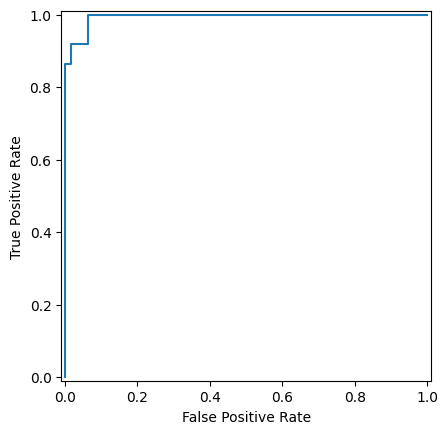

In [83]:
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 0], pos_label=0)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### Other linear models

Other variants of linear models are distinguished by the type of regularization that is applied in error minimization:
- `Lasso`: Weights have L1 regularization to favor sparsity, 
- `ElasticNet`: Weights have both L1 and L2 regularization,
- ...

## Neural networks

A neural network classifier, where you can choose the hidden layers and their units, the training procedure (SGD, LBGFS, Adam), regularization, etc. The loss to be minimized is *cross-entropy loss*.

The L2 regularization parameter is $\alpha$, larger ⇒ more regularization.

In [84]:
from sklearn.neural_network import MLPClassifier

In [85]:
nn = MLPClassifier(
    hidden_layer_sizes=(
        8,
    ),  # input and output layer sizes automatically selected by fit()
    activation="tanh",  # activation function
    solver="sgd",  # {‘lbfgs’, ‘sgd’, ‘adam’}
    alpha=1e-2,  # L2 regularization (is divided by #samples)
    max_iter=100,  # epochs
    tol=1e-6,  # training loss improvement tolerance (training is halted if training loss stops improving)
    n_iter_no_change=50,  # patience for training loss improvement
    batch_size=32,
    shuffle=True,  # reshuffle samples between epochs
    learning_rate="constant",  # can also be adaptive
    learning_rate_init=1e-3,  # (initial) learning rate
    momentum=0.9,
    nesterovs_momentum=False,  # if you want to use Nesterov’s momentum, only for SGD
    early_stopping=False,  # if you want to use a hold-out set for early stopping
    verbose=True,
)

nn.fit(X_dev, y_dev)

Iteration 1, loss = 0.54045311
Iteration 2, loss = 0.52002203
Iteration 3, loss = 0.52970405
Iteration 4, loss = 0.48482713
Iteration 5, loss = 0.59078394
Iteration 6, loss = 0.50586582
Iteration 7, loss = 0.45016611
Iteration 8, loss = 0.43059474
Iteration 9, loss = 0.63971284
Iteration 10, loss = 0.61806077
Iteration 11, loss = 0.66378503
Iteration 12, loss = 0.66364064
Iteration 13, loss = 0.66330432
Iteration 14, loss = 0.66306481
Iteration 15, loss = 0.66305279
Iteration 16, loss = 0.66286728
Iteration 17, loss = 0.66291454
Iteration 18, loss = 0.66288599
Iteration 19, loss = 0.66317863
Iteration 20, loss = 0.66284827
Iteration 21, loss = 0.66289081
Iteration 22, loss = 0.66286423
Iteration 23, loss = 0.66288918
Iteration 24, loss = 0.66295052
Iteration 25, loss = 0.66304272
Iteration 26, loss = 0.66284255
Iteration 27, loss = 0.66286485
Iteration 28, loss = 0.66287840
Iteration 29, loss = 0.66300283
Iteration 30, loss = 0.66293827
Iteration 31, loss = 0.66304387
Iteration 32, los

,hidden_layer_sizes,"(8,)"
,activation,'tanh'
,solver,'sgd'
,alpha,0.01
,batch_size,32
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,100
,shuffle,True
,random_state,None


You can access learning curve and other training statistics in the `MLPClassifier` object

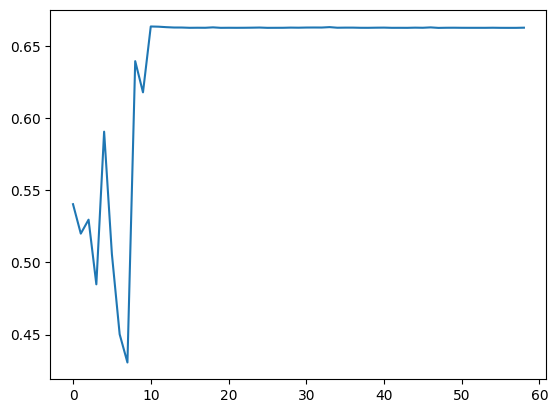

In [86]:
plt.plot(nn.loss_curve_)

In [87]:
nn.score(X_test, y_test)

0.63

## Support vector machines

Support vector machines for classification (C-SVM).

This class solves the soft-margin problem:
$\begin{align}\begin{aligned}\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i\\\begin{split}\textrm {subject to } & y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i,\\
& \zeta_i \geq 0, i=1, ..., n\end{split}\end{aligned}\end{align}$
where $C$ controls the strenght of regularization: larger $C$ ⇒ smaller regularization.

In the dual form, the kernel trick is applied in the scalar products $K(x_i, x_j) = \phi (x_i)^T \phi (x_j)$.

In [88]:
from sklearn.svm import SVC

In [89]:
svm = SVC(
    C=1.0,
    kernel="linear",
    class_weight="balanced",  # use this to balence unbalanced classes
    verbose=True,
)

For the linear SVM, the class `LinearSVC` can also be used, where the kernel trick is not applied.

In [90]:
svm.fit(X_dev, y_dev)

[LibSVM]................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,True


You can access statistics concerning the fit, such as number of support vectors per class:

In [91]:
svm.n_support_

array([20, 31], dtype=int32)

In [92]:
svm.score(X_test, y_test)

0.97

## Decision trees

Decision trees which learn a hiearachical decision function by successive refinements of splits. Model complexity is controlled by tree depth or samples per node.

In [93]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [94]:
dt = DecisionTreeClassifier(max_depth=3)

In [95]:
dt.fit(X_dev, y_dev)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [96]:
dt.score(X_test, y_test)

0.93

[Text(0.5416666666666666, 0.875, 'x[20] <= 16.795\ngini = 0.468\nsamples = 469\nvalue = [175, 294]'),
 Text(0.3333333333333333, 0.625, 'x[27] <= 0.136\ngini = 0.162\nsamples = 314\nvalue = [28.0, 286.0]'),
 Text(0.4375, 0.75, 'True  '),
 Text(0.16666666666666666, 0.375, 'x[10] <= 1.048\ngini = 0.035\nsamples = 280\nvalue = [5, 275]'),
 Text(0.08333333333333333, 0.125, 'gini = 0.028\nsamples = 279\nvalue = [4, 275]'),
 Text(0.25, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.5, 0.375, 'x[21] <= 25.62\ngini = 0.438\nsamples = 34\nvalue = [23, 11]'),
 Text(0.4166666666666667, 0.125, 'gini = 0.375\nsamples = 12\nvalue = [3, 9]'),
 Text(0.5833333333333334, 0.125, 'gini = 0.165\nsamples = 22\nvalue = [20, 2]'),
 Text(0.75, 0.625, 'x[11] <= 0.473\ngini = 0.098\nsamples = 155\nvalue = [147, 8]'),
 Text(0.6458333333333333, 0.75, '  False'),
 Text(0.6666666666666666, 0.375, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(0.8333333333333334, 0.375, 'x[26] <= 0.191\ngini = 0.039\nsa

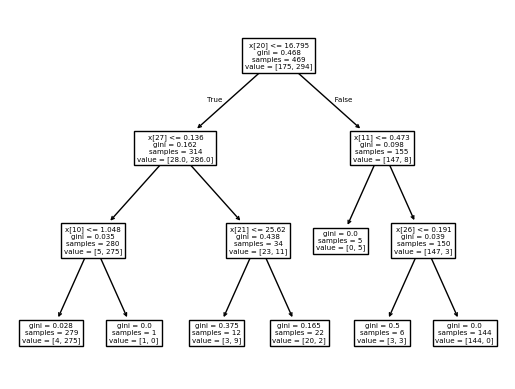

In [97]:
plot_tree(dt)

### Exercise

Perform a model selection on one of these models (e.g. SVM with regularization, kernel type; NN with different hidden units, regularization, learning rate, epochs, ...), and report test **balanced accuracy**, (average) **validation accuracy**, and **test AUC**. You must use the test splits fixed above, otherwise you're free to perform the model selection as you wish (number of folds, grid or random search, ...). Apply also feature rescaling, if you deem it appropriate.

Submit the results here: https://tinyurl.com/ml2025-sklearn

In [98]:
from sklearn.datasets import load_breast_cancer

In [99]:
X, y = load_breast_cancer(return_X_y=True)

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=100, stratify=y, shuffle=True, random_state=42
)